In [3]:
# !pip3 install -q -r requirements.txt
# !pip install swig
# !pip install gymnasium[box2d]
# !pipreqsnb --force

In [496]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import tqdm.notebook as tqdm

import gymnasium as gym
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torchsummary as summary

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from IPython import display

In [497]:
ENV = gym.make("LunarLander-v2", continuous = False, gravity = -10.0, enable_wind = False, wind_power = 15.0, turbulence_power = 1.5, render_mode='rgb_array')
SS = ENV.observation_space # continuous 
DIM_S = SS.shape[0] # 8-dimensional
N_ACTIONS = ENV.action_space.n # finite action space, 4 actions
ACTIONS_STR = ('X','L','B','R')

The state is an 8-dimensional vector: 
- the coordinates of the lander in x & y,
- its linear velocities in x & y,
- its angle, its angular velocity,
- two booleans that represent whether each leg is in contact with the ground or not.

In [498]:
SS.low, SS.high, DIM_S

(array([-1.5      , -1.5      , -5.       , -5.       , -3.1415927,
        -5.       , -0.       , -0.       ], dtype=float32),
 array([1.5      , 1.5      , 5.       , 5.       , 3.1415927, 5.       ,
        1.       , 1.       ], dtype=float32),
 8)

In [499]:
# stochastic init state
ENV.reset()

(array([-0.00709496,  1.3995366 , -0.71865314, -0.50595176,  0.00822802,
         0.1627857 ,  0.        ,  0.        ], dtype=float32),
 {})

In [500]:
def rr(env=ENV):
    """quick render fix assuming env's render_mode='rgb_array' """
    # plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(env.render())
               
def act(action_id: int, env=ENV):
    """filters unnecessary output"""
    return env.step(action_id)[:3]

In [501]:
new_state = act(2) # [state, reward, done, info, ...]
new_state

(array([-0.01414013,  1.3885281 , -0.7129303 , -0.48933885,  0.01653793,
         0.16621509,  0.        ,  0.        ], dtype=float32),
 1.382634956873386,
 False)

In [520]:
# auxillary functions
def lin_ann_rate(i, n_total):
    return 1 - i / n_total

def exp_ann_rate(i, thr=0.0001, la=2/300, drop=0.001):
    """exponential decay with i --> +inf, provides descending values within range [expl_thr, 1],
        la=0.01 means ~36% left after 100 iterations, results < drop value are zeroed"""
    exp = np.exp if isinstance(i, np.ndarray) else torch.exp
    result = thr + (1 - thr) * exp(- la * i)
    if drop:
        result[result <= drop] = 0
    return result

def anneal_comparison(n=500):
    i = np.arange(n)
    ax = sns.lineplot(lin_ann_rate(i, n), linewidth=1.2, label=f"base")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"Annealing rates comparison", fontsize=15)
    ax.set_xlabel('iterations - 1')
    for j in np.arange(2, 100, 10):
        result = exp_ann_rate(i, thr=0, la=j/n, drop=1e-4)
        ax = sns.lineplot(result, linewidth=1, ax=ax, label=f"la={j}")

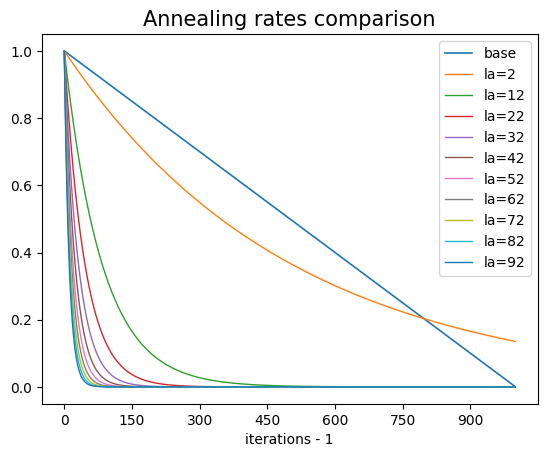

In [521]:
anneal_comparison(1000)

In [522]:
class RandAgent():
    """baseline agent that performs random actions"""
    def __init__(self, n_actions=N_ACTIONS, id_to_str=ACTIONS_STR):
        self.n_actions = n_actions
        self.id_to_str = id_to_str
        
    def act(self, state):
        action = random.randrange(self.n_actions)
        # print('RANDOM!!')
        return action

    def walk(self, max_length, render=False, **actkwargs):
        """take max_length actions by agent N"""
        states, actions, rewards = [], [], []
        # initialization state
        state = ENV.reset()[0]
        for i in range(max_length):
            # perform an action
            action = self.act(state, **actkwargs)
            new_state, reward, done = act(action)
            # log 
            actions.append(action)
            states.append(state) # append OLD state, everything breaks if you start from new
            rewards.append(reward)
            state = new_state
            # continuos visualization w/ proper interrupt
            if render:
                try:
                    rr()
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    time.sleep(1e-20)
                except KeyboardInterrupt:
                    break
            if done:
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory

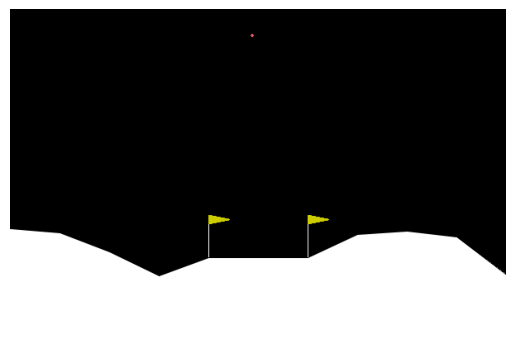

In [400]:
agent = RandAgent()
results = agent.walk(max_length=20, render=True)

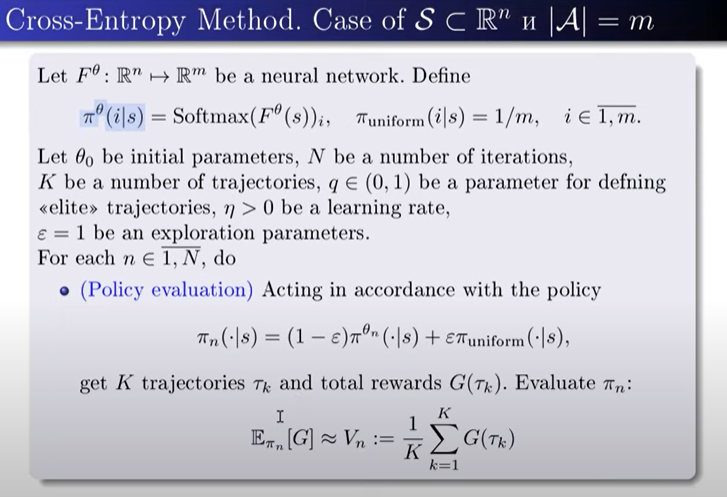
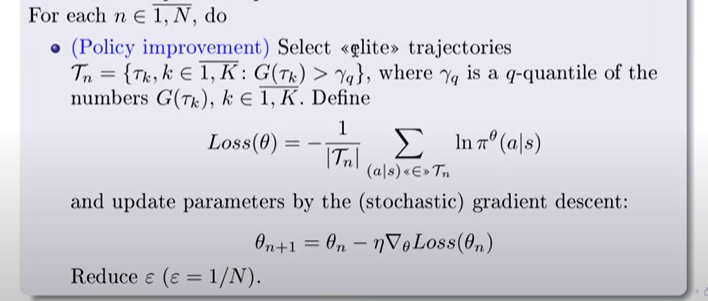

In [545]:
class CrossEntropyNNAgent(RandAgent):
    def __init__(self, d_states=DIM_S, n_actions=N_ACTIONS, id_to_str=ACTIONS_STR, hidden_d=(100, 80), device=DEVICE):
        """CrossEntropy algorithm actor, optimizes expected reward by policy, given by neural network """
        super().__init__(n_actions, id_to_str)
        self.d_states = d_states
        self.expl = 1
        
        self.loss = nn.CrossEntropyLoss()
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(in_features=self.d_states, out_features=hidden_d[0]),
            nn.ReLU(),
            nn.Linear(hidden_d[0], hidden_d[1]),
            nn.ReLU(),
            nn.Linear(hidden_d[1], n_actions))
        
        self.log = []
        self.hp = {}

    def act(self, state):
        """policy = drawing a random sample from current distribution on actions, 
            given by network output (softmax of logits to get probits!) 
            + uniform distribution [0..1] on actions w/ exponential smoothing factor=eps, 
            otherwise this policy would be almost completely deterministic (as NN is except its initialization)"""
        with torch.inference_mode():
            action_dstr = (1 - self.expl) * nn.functional.softmax(self.model(torch.Tensor(state)).detach(), dim=-1) + self.expl * torch.tensor([1 / self.n_actions] * self.n_actions)
            action = torch.multinomial(action_dstr, num_samples=1, replacement=True).item() # sample one w/ replacement, equivalent of np.random.choice or np.argmax(np.random.multinomial(1,p,None))
        return action

    def learning_curve(self, show_max=True, ax=None):
        """plots rewards vs iterations of algorithm"""
        ax = sns.lineplot(self.log, linewidth=1.0, ax=ax, label=f"lr={self.hp['lr']}")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(f"Mean reward over {self.hp['n_trajectories']} trajectories of length < {self.hp['max_length']}", fontsize = 10)
        ax.set_xlabel('iterations - 1')
        # ax.set_yscale('symlog')
        ax.legend()
        if show_max:
            ax.axhline(y=max(self.log), color='r', linestyle='-', linewidth=0.5)
        return ax
        
        
    def fit(self, n_iterations, max_n_epochs, lr=0.01, n_trajectories=100, max_length=50, q=0.8, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (w/ length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories

        max_n_epochs controls max possible NN training epochs per each iteration

        lr defines learning rate of built-in Adam optimizer
        
        verbose>0 sets up a period of learning process rendering

        NB: .fit internally uses .act method of child class(this), doesn't inherit parental
        """
        # save fitting hyperparameters for comparison
        ap = locals()
        self.hp = {k: ap[k] for k in ap.keys() - ['self', 'verbose', 'n_iterations', 'n_epochs']}
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        iterations_pbar = tqdm.trange(n_iterations, position=0, leave=True, colour="#a2d2ff")
        dh = display.display(display_id=True)
        expl_rates = []
        for i in iterations_pbar:
            self.model.eval()
            # policy evaluation (act with current policy or sample n_det deterministic from that one)
            trajectories = [self.walk(max_length=max_length) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)
            
            # policy improvement
            # get q-quantile of current reward distribution and filter out better trajectories
            gamma = np.quantile(rewards, q)
            elite_ids = (rewards > gamma).nonzero()[0]
            if elite_ids.any():
                # extract (lists of) state and (corresponding) action tensors from elite trajectories
                states_l, actions_l = zip(*((np.stack(trajectories[ei]['s']), np.stack(trajectories[ei]['a'])) for ei in elite_ids))
                states, actions = torch.FloatTensor(np.concatenate(states_l)).to(self.device), torch.LongTensor(np.concatenate(actions_l)).to(self.device)
                epochs_pbar = [0] if (max_n_epochs == 1 or i==0) else tqdm.trange(n_epochs, position=1, leave=False, colour="#ffc8dd") # order matters
                self.model.train()
                for e in epochs_pbar:
                    # forward pass
                    pred_actions = self.model(states)
                    loss = self.loss(pred_actions, actions)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # explore less (descending from 1 to 0)
                self.expl = exp_ann_rate(torch.Tensor([i]), thr=0, la=52/n_iterations, drop=1e-4).item()
                expl_rates.append(self.expl)
                # less stochastic gradients (ascending from 1 to max_n_epochs)
                n_epochs = 1 + round((1 - exp_ann_rate(torch.Tensor([i]), thr=0, la=2/n_iterations, drop=None).item()) * (max_n_epochs - 1))
                iterations_pbar.set_postfix_str(f'avg reward: {avg_reward.item():.2f}, loss: {loss.detach().item():.2f}, expl: {self.expl:.2e}, n_epochs: {n_epochs}', refresh=True)
            
            # visualization (plotting starts after at least 1 iteration)
            if verbose and i > 0 and (i + 1) % verbose == 0:
                # print(f"iteration {i + 1}, mean total reward: {avg_reward}")
                figure, axes = plt.subplots(1, 2, figsize=(12,5))
                ax = self.learning_curve(ax=axes[0])
                
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                sns.lineplot(expl_rates, linewidth=0.5, ax=ax2, label="exploration", color='blueviolet')
                
                ax = sns.histplot(rewards, kde=False, bins=20, ax=axes[1])
                ax.axvline(gamma, 0, 20, color='r')
                ax.set_xlabel('Rewards')
                ax.set_title(f'Current distribution of rewards and its {q:.2f}-quantile ', fontsize = 10)
                
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious
        return avg_reward

  0%|          | 0/500 [00:00<?, ?it/s]

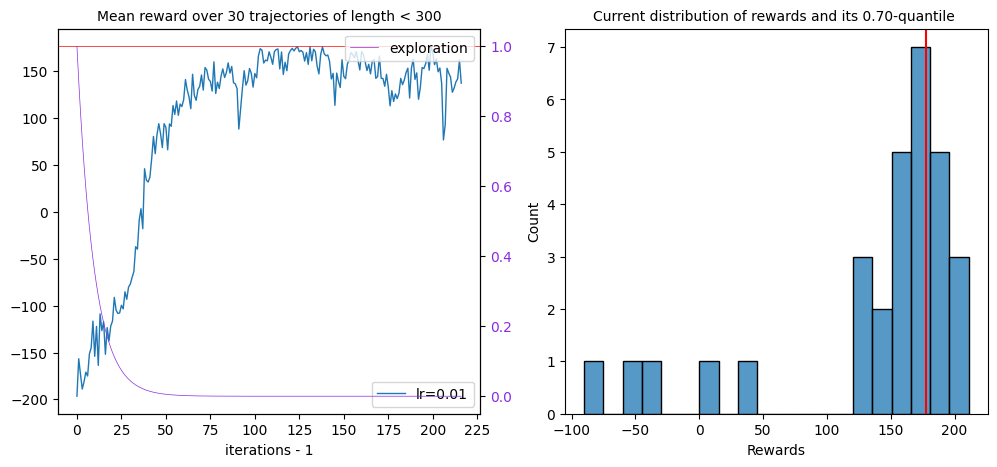

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [547]:
agent_cenn = CrossEntropyNNAgent()
agent_cenn.fit(n_iterations=500, max_n_epochs=10, lr=0.01, n_trajectories=30, max_length=300, q=0.7, verbose=1)

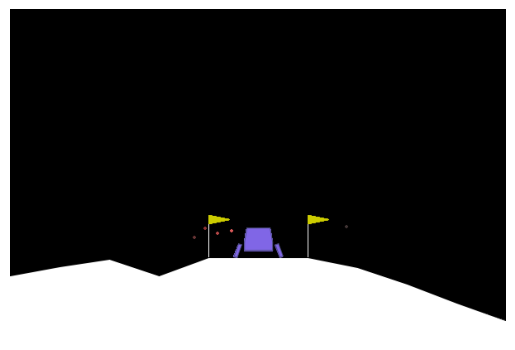

In [548]:
results = agent_cenn.walk(max_length=200, render=True)

# Results
This network is being optimized via full batch GD on stochastic data (and you call that -- SGD) and hard to train 'as is'. 

According to the [lunarlanderv2 manual](https://gymnasium.farama.org/environments/box2d/lunar_lander/), 
>An episode is considered a solution if it scores at least 200 points.

but I am not patient enough and couldn't reach anything over 190 on average(

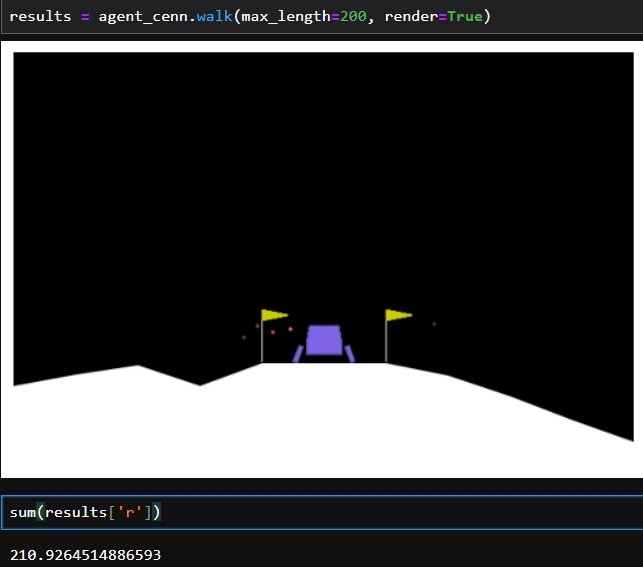

Anyways, it's not even possible to always reach high rewards starting from random point and random acceleration

Moreover, without all that stuff below it yields noisy periodic patterns and doesn't even saturate/improve nicely

For some unknown reason, ascending trend becomes unstable again after ~200 iterations
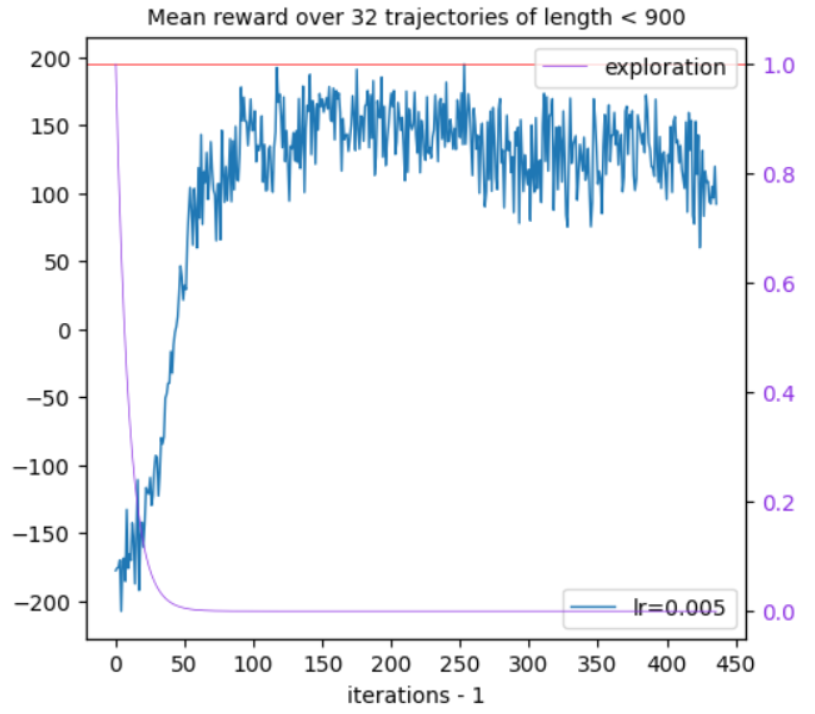
## Hyperparameter search
It takes lots of engine runs to even hover above landing spot, therefore a trajectory should be (reasonably) long, **max_length** >= 200
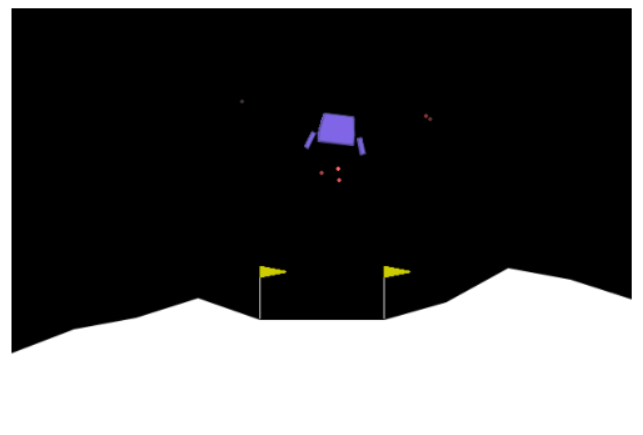

Reward expectation could be approximated good enough (established by looking at rewards distribution histogram) with **n_trajectories** >= 20 and **q** >= 0.6

## Modifications/improvements:
I came up with some ideas to improve stability and resulting reward

- The space of actions is continuous $\mathit{A}\subset\mathbb{R}^8$ therefore to obtain a proper policy we need models with rather high capacity (not to underfit).
  As shallow wide networks tend to generalize poorly I've decided to use two layers (120, 60) with ReLU nonlinear activations.
  Is it even possible to overfit NN that learns from random data?
  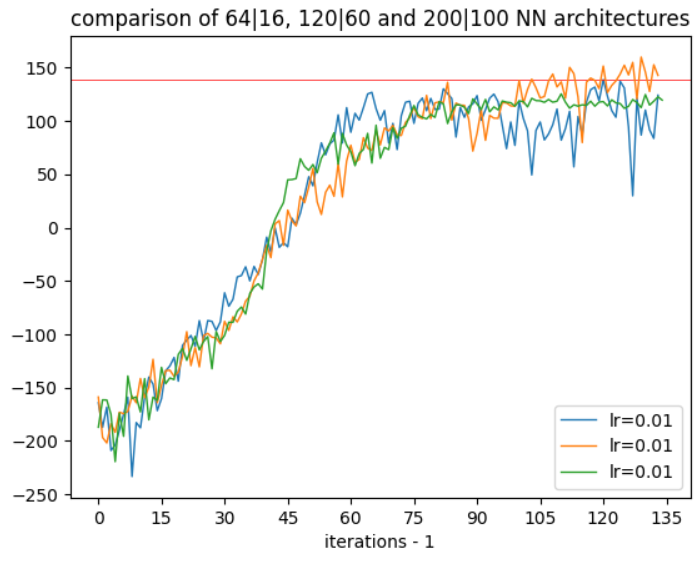

- My action distribution (to be sampled) is a combination of two: net out and uniform (w/ exponential smoothing given by attribute **agent.expl**) 
  As for 'exploration' parameter, I apply exponential decay rule with large lambda as its goal is to protect real action distribution at the very beginning, from 'unfair' NN weight initialization hence it has to descend much faster than iterations (i.e. instead of linear)
  $$agent.expl = \left[thr + (1 - thr) * \exp(- \lambda_{large} * i)\right]_{>d=1e-4}, \quad thr =\lim\limits_{i\to\infty} agent.expl $$
  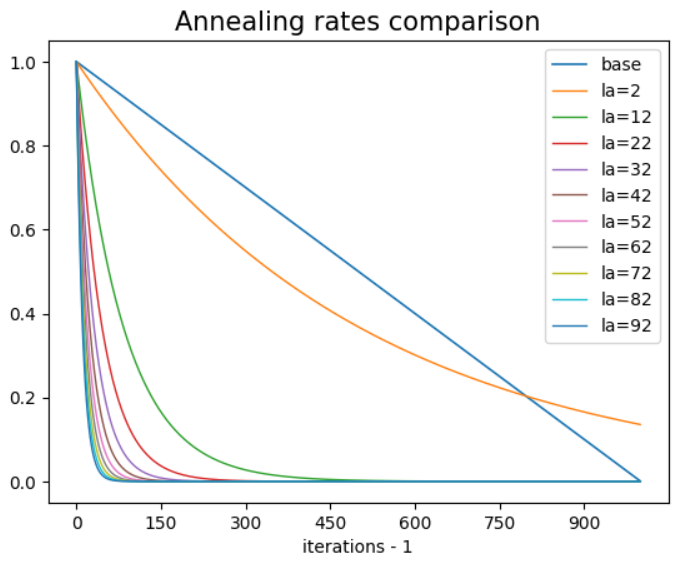

- Moreover, at each iteration I perform training for several epochs to stabilize weight updates and use data (a bit more) effectively.
  This is controlled via internal **n_epochs** parameter within **[1...max_n_epochs]** that slowly grows with iterations exponentially; It brings stability to the learning process, but  nevertheless, it's not a great idea to fine-tune NN to potentially bad data thus **max_n_epochs** should be ~ 10
  $$n\_epochs = \left[max\_n\_epochs * \left[1 - \exp(- \lambda_{small} * i)\right]\right]_{int}$$
  taking learning rate **lr** into consideration, those steps could be called 'fine' equivalent of 'coarse' step with higher learning rate
  
  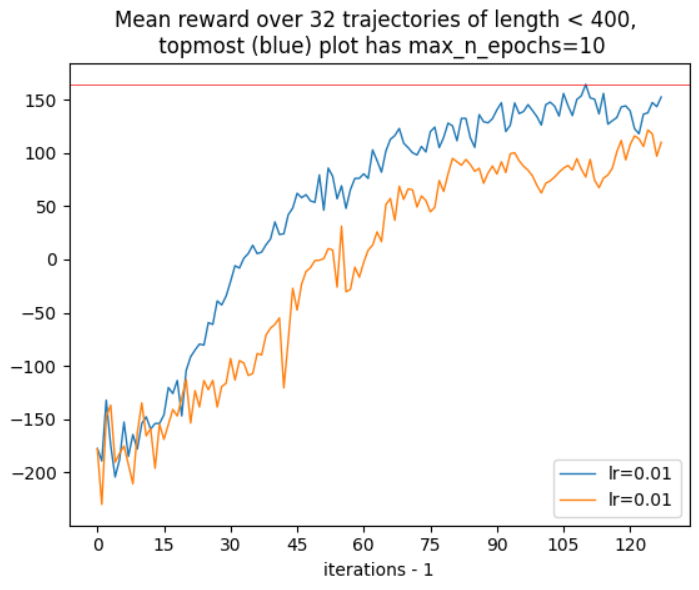